<a href="https://colab.research.google.com/github/9645258/aiffel/blob/main/02_goingdeeper/01_nlp%5BGD-08%5Dnlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GD NLP 08 : Seq2seq으로 번역기 만들기**

- **한영 번역기 만들기**  

- **번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.**  
구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.  

- **Attentional Seq2seq 모델이 정상적으로 구동된다.**  
seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.  

- **테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.**  
테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.  

## **1. 데이터 준비**


### **1-1. 라이브러리 import**

In [ ]:
import re
import os
import io
import random
import tarfile
import numpy as np
import pandas as pd
from tqdm import tqdm
from konlpy.tag import Mecab

import tensorflow as tf

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
mpl.rcParams['font.family'] = 'NanumBarunGothic'
mpl.rcParams['font.size'] = 12

In [ ]:
print(mpl.rcParams['font.family'])
print(mpl.rcParams['font.size'])

['NanumBarunGothic']
12.0


### **1-2. 데이터 import**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- **국문 및 영문 데이터 import**

In [ ]:
path_to_en = "/content/drive/MyDrive/Colab Notebooks/aiffel/01_data/02-1_nlp/08/korean-english-news-v1/train/korean-english-park.train.en"
path_to_ko = "/content/drive/MyDrive/Colab Notebooks/aiffel/01_data/02-1_nlp/08/korean-english-news-v1/train/korean-english-park.train.ko"

In [ ]:
with open(path_to_ko, "r") as f:
    kor_raw = f.read().splitlines()

In [ ]:
with open(path_to_en, "r") as f:
    eng_raw = f.read().splitlines()

### **1-3. 데이터 확인**

- **데이터 수 확인**

In [ ]:
print('국문 데이터 수:', len(kor_raw))
print('영문 데이터 수:', len(eng_raw))

국문 데이터 수: 94123
영문 데이터 수: 94123


- **데이터 확인**

In [ ]:
print('<국문 데이터>\n', random.sample(kor_raw, 30), '\n')
print('<영문 데이터>\n', random.sample(eng_raw, 30))

<국문 데이터>
 ["음향 편집상은 영화 '이와 지마의 편지'의 앨런 로버트 머레이와 법 애스먼 팀에게 돌아갔다.", '한편 로드리게스는 지난 2일 열린 미네소타 트윈스와 뉴욕 양키스와의 경기에서 병살타를 막기 위해 1루로 전력 질주하다 넘어져 부상을 입었다.', '아들은 아버지로부터 사업을 이어받는다.', '"만약 영화가 엄청난 흥행 성적을 기록한 지점에 스파이크를 찍은 그래프를 본다면 그것은 미국 지하세계의 진실한 지도를 보는 것과 같다.', '김 씨는 6년 전 BBK를 운영하는 동안 주가를 조작하고 및 기업 자금을 횡령한 혐의로 체포되었다.', '대통령 당선인의 상원의원직 후임으로 지명된 롤랜드 버리스는, 자신에 대한 이야기를 할 때 스스로를 3인칭으로 지칭하며, 자신에게는 아무런 문제가 없고 상원의원직 지명에도 아무런 문제가 없다고 말했습니다.', 'WBC 베네수엘라戰, 승리를 기원합니다', '부동산 보유세가 2005년에 비해 올해 12배 가량 증가함에따라 서울 강남의 고급아파트에 거주하는 약 40만 명의 부자들이 세금 폭탄을 맞게 되었다고 코리아 타임스가 보도했다.', '포레티는 65세가 넘는 사람의 6%에 달하는 사람들이 고통을 받고 있는 질환을 갖고 있다.', '스페인에서는 또한 임산부가 신체적으로나 정신적으로 위험하다는 의사 진단을 받을 경우 언제든 낙태를 할 수 있다.', '그는 사고 전투기가 저공비행을 하는 것을 목격했을 당시 20가구가 사는 주택가에서 얼마 떨어지지 않은 쇼핑센터로 점심을 먹기 위해 가던 중이었다.', '온몸으로 말하는 기상캐스터', "to the improvement 에서 to는 적용의 대상을 나타내는\xa0전치사로서 to는 to the improvement  and (to) the increase 와\xa0같이 the increase 에도 걸린다는 것에 유의해야 한다. his well-being과 his wealth에서 his는 man's를 대신하는 것이다.", '미 당국은 이전에 돌아다니는 들소를 포획, 브루셀라 감염 

### **1-4. 중복 데이터 제거**

- **중복 데이터 제거**  
zip으로 병렬 쌍을 고정하여 set로 중복 데이터 제거

In [ ]:
cleaned_corpus = set(zip(kor_raw,eng_raw))

- **중복 데이터 제거 후 데이터 수 확인**

In [ ]:
print("중복 데이터 제거 후 데이터 수:", len(cleaned_corpus))

중복 데이터 제거 후 데이터 수: 78968


- **중복 데이터 제거 후 데이터 확인**

In [ ]:
random.sample(cleaned_corpus, 10)

[('비위생적인 환경과 깨끗한 물의 부족으로 일부 피난캠프에서는 설사와 이질이 발생했다.',
  'Unhygienic conditions and a lack of clean water have contributed to isolated cases of diarrhea and dysentery in some refugee camps.'),
 ('러시아 보안국 최고 책임자는 바사예프가 ‘특수작전’에 의한 전투 중에 사망했다고 발표했지만 반군 웹사이트는 바사예프를 비롯, 또 다른 세 명의 반군들이 폭발물을 가득 실은 트럭이 터지는 바람에 사망했다고 바사예프의 사망 소식을 전했다.',
  'But a pro-rebel website said Basayev and three other militants died when a truck carrying explosives blew up accidentally.'),
 ('마돈나의 입양 문제와 관련, 65명의 인권 변호인단을 이끌고 있는 저스틴 드존지 변호사 또한 카인자 장관의 결정으로 입양 진행이 중단될 수 있다고 밝혔다.',
  "a human rights lawyer who led a 65-member rights group challenge to Madonna's adoption, also said the minister's decision could halt the adoption process."),
 ('미국 버클리 소재 캘리포니아 주립대학 연구진은 인도네시아 해안에 서식하는 야생 문어가 매력적인 상대에 대해 소심하거나 로맨틱하지 않은 독선적인 행동은 절대로 하지 않는다는 사실을 밝혀냈다.',
  'The study by researchers from the University of California, Berkeley, who journeyed off the coast of Indonesia found that wild octopuses are far from the shy, unromantic loners 

### **1-5. 데이터셋 변환**

In [ ]:
dataset = pd.DataFrame(cleaned_corpus, columns=["kor", "eng"])

In [ ]:
dataset.sample(10)

,kor,eng
15986,대다수의 한국인들은 현재의 대통령 임기를 바꾸려는 노무현 대통령의 개헌안이 국회나 ...,A majority of South Koreans believe President ...
75331,교정국장은 “재소자들이 화장실의 변기를 혀로 청소하라는 압력을 받았다는 보고도 들어...,"""These were improper, illegal heinous and desp..."
36587,이 용의자는 지난 몇 년간 아르헨티나 국적으로 칼로스 헥토르 프로멘바움이란 이름을 ...,The suspect had been a regular customer at the...
41925,올해 1/4분기 쿠바 방문객은 15% 증가했다.,"HAVANA, Cuba (CNN) Cuba said Wednesday that it..."
67980,이란은 지난 몇주간 원심분리기 수백대를 설치했으며 다음달까지 3000번의 작업을 가...,Iran has installed hundreds of centrifuges wit...
43690,여성 가수의 부재는 올해 더 많이 부각되고 있다. 다른 주요 수상 분야인 올해의 앨...,The absence of women may be more glaring this ...
18882,"북한,“폭정의 전초기지” 발언에 대해 미국에 사과 요구",North Korea's leadership demanded an apology y...
9430,한 러시아 남성이 이발비가 비싸다는 이유로 미용사를 살해했다.,"MOSCOW, Russia (CNN) A Russian man is accused ..."
24238,퍼거슨 감독은 “동점골은 우리에게 승리에 대한 인센티브를 줬으며 승리를 거둔 선수들...,"""The equaliser gave us the incentive to go on ..."
76485,이번 회동은 두 국가 해법 등 오바마가 추구하는 포괄적 평화 정착 계획의 일환으로 ...,Senior White House officials say this meeting ...


## **2. 데이터 정제**

### **2-1. 토큰 수 기준 데이터 선별**

- **토큰 길이가 40 이하인 데이터 선별**

In [ ]:
def filt_sentence_length(df, col, sentence_len):
    df = df.copy()
    df["len"] = df[col].apply(lambda x: len(x.split()))
    df = df.loc[df["len"] < sentence_len]
    df.drop(["len"], axis="columns", inplace=True)
    return df
    
dataset = filt_sentence_length(dataset, "kor", 40)
dataset = filt_sentence_length(dataset, "eng", 40)

### **2-2. 정규식을 활용한 정제**

- **국문 데이터 정제화 함수**

In [ ]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([0-9?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

- **국문 데이터 정제화**

In [ ]:
dataset["kor"] = dataset["kor"].apply(preprocess_sentence)

- **영문 데이터 정제화 함수**

In [ ]:
def preprocess_with_token(sentence, decoder_data=False):
    sentence = preprocess_sentence(sentence)
                                   
    if decoder_data:
        sentence = "<sos> " + sentence + " <eos>"
    return sentence

- **영문 데이터 정제화**

In [ ]:
dataset["eng"] = dataset["eng"].apply(lambda x: preprocess_with_token(x, True))

### **2-3. 정제 데이터 확인**

- **정제 데이터 수 확인**

In [ ]:
print('정제 국문 데이터 수:', len(dataset["kor"]))
print('정제 영문 데이터 수:', len(dataset["eng"]))

정제 국문 데이터 수: 74925
정제 영문 데이터 수: 74925


- **정제 데이터 문장 확인**

In [ ]:
dataset.sample(10)

,kor,eng
9423,"아이티 , 춤추던 학생들로 인해 학교건물 붕괴",<sos> kids dancing causes haiti school collaps...
44538,"봉사하는 사회 , 그리고 기개가 있는 국가를 건설하는 책임있는 시민이 되기를 말입니다 .","<sos> responsible citizens , building communit..."
34322,최근 코리아 타임스가 실시한 여론 조사를 보면 응답자들은 미국 비자 등록 절차가 까...,<sos> a recent korea times survey has shown th...
66525,뉴욕 증권 거래소에서 워렌 레비슨입니다 .,<sos> warren levinson at the new york stock ex...
32662,산토리니는 매년 수많은 관광객을 맞이하는 가장 볼만 하고 고급스런 관광객의 행선지 ...,<sos> santorini welcomes hundreds of thousands...
25855,그중 한 사람은 경찰이었으며 나머지는 시민이었습니다 .,<sos> one of them was a policeman and the othe...
62061,태풍으로 7 4 4 여 가구의 전기가 끊겼고 일부 지역에서는 물 공급이 중단됐다 .,"<sos> power outages hit 7 4 4 households , and..."
25849,산업 감시 회사인 오일 체인지 인터내셔널 전무 이사인 스티브 크레츠만은 중동에서는 ...,"<sos> steve kretzmann , executive director of ..."
41557,강한 어조로 쓰인 한 잡지 기사는 인도에서의 병원 생활을 끝낸 달라이라마가 조국의 ...,"<sos> called on the dalai lama , who ended a h..."
12207,이전 미국은 북한이 6 자 회담에서 합의한 핵 프로그램 신고를 완전히 이행하지 않았...,<sos> washington has accused pyongyang of not ...


## **3. 데이터 토큰화**

### **3-1. 토큰화 함수**

In [ ]:
def tokenize(corpus, vocab_size, maxlen, encoder_TF=True):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '', oov_token = "<UNK>", num_words = vocab_size)
    corpus_input = corpus
    
    if encoder_TF:
        m = Mecab()
    
        corpus_input = []
        for sentence in corpus:
            corpus_input.append(m.morphs(sentence))
    
    tokenizer.fit_on_texts(corpus_input)
    
    if vocab_size is not None:
        words_frequency = [w for w,c in tokenizer.word_index.items() if c >= vocab_size + 1]
        for w in words_frequency:
            del tokenizer.word_index[w]
            del tokenizer.word_counts[w]
    
    tensor = tokenizer.texts_to_sequences(corpus_input)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=maxlen)
    return tensor, tokenizer

### **3-2. 국문 토큰화**

In [ ]:
enc_tensor, enc_tokenizer = tokenize(dataset["kor"], None, None, encoder_TF=True)
print("국문 토큰 수:", f"{len(enc_tokenizer.word_index):,}")

국문 토큰 수: 49,012


### **3-3. 영문 토큰화**

In [ ]:
dec_tensor, dec_tokenizer = tokenize(dataset["eng"], None, None, encoder_TF=False)
print("영문 토큰 수:", f"{len(dec_tokenizer.word_index):,}")

영문 토큰 수: 42,931


## **4. 모델 설계**


### **4-1. BahdanauAttention**

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

### **4-2. Encoder**

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, dropout=0.2, return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

### **4-3. Decoder**

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, dropout=0.2, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

### **4-4. 모델 구조 확인**

In [ ]:
SRC_VOCAB_SIZE = len(enc_tokenizer.word_index) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.word_index) + 1

units = 256
embedding_dim = 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

### **4-5. 옵티마이저 설정**

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

### **4-6. 손실 함수 설정**

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

### **4-7. 학습 함수 설정**

In [ ]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<sos>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

## **5. 모델 훈련 및 평가**


### **5-1. 모델 훈련**

In [ ]:
EPOCHS = 20
BATCH_SIZE = 64


for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE], dec_tensor[idx:idx+BATCH_SIZE], encoder, decoder, optimizer, dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

Epoch 20: 100%|██████████| 1171/1171 [07:13<00:00,  2.70it/s, Loss 1.1070]


### **5-2. 모델 평가 함수**

- **번역 수행 함수**

In [ ]:
def evaluate(sentence, encoder, decoder):
    m = Mecab()
    
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    sentence = m.morphs(sentence)
    
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=enc_tensor.shape[-1], padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<sos>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<eos>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

- **matrix 생성 함수**

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 15, 'fontfamily' : 'NanumBarunGothic'}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

- **번역 및 시각화 함수**

In [ ]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('국문: %s' % (sentence))
    print('번역을 수행한 영문: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))

### **5-3. 모델 평가**

국문: ['오바마', '는', '대통령', '이', '다', '.']
번역을 수행한 영문: obama is a former president . <eos> 


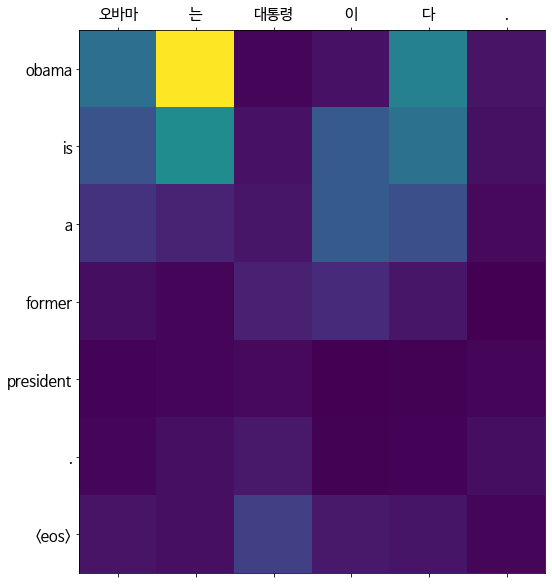

In [ ]:
translate("오바마는 대통령이다.", encoder, decoder)

국문: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
번역을 수행한 영문: they are also a huge number of the city . <eos> 


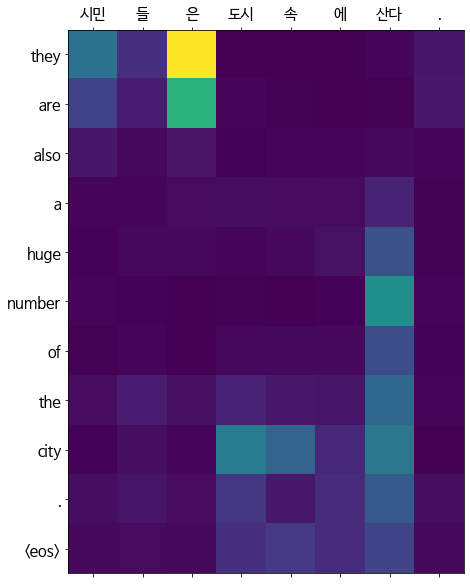

In [ ]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

국문: ['커피', '는', '필요', '없', '다', '.']
번역을 수행한 영문: he says . <eos> 


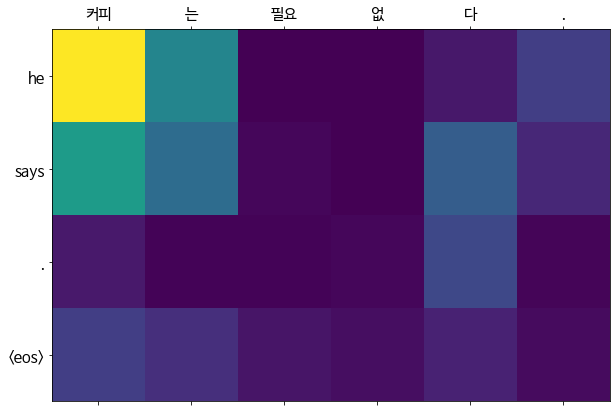

In [ ]:
translate("커피는 필요 없다.", encoder, decoder)

국문: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
번역을 수행한 영문: six were killed . <eos> 


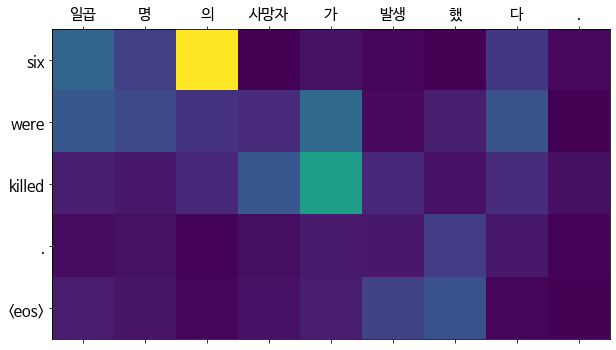

In [ ]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

국문: ['여름', '은', '날씨', '가', '덥', '다', '.']
번역을 수행한 영문: the summer morning , the weather is the best way to get the new weather . <eos> 


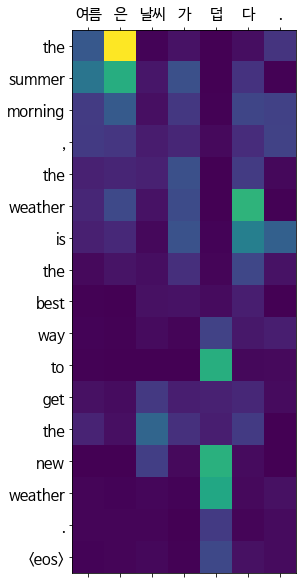

In [ ]:
translate("여름은 날씨가 덥다.", encoder, decoder)

국문: ['그', '와', '그녀', '는', '결혼', '을', '한다', '.']
번역을 수행한 영문: he is married to her marriage . <eos> 


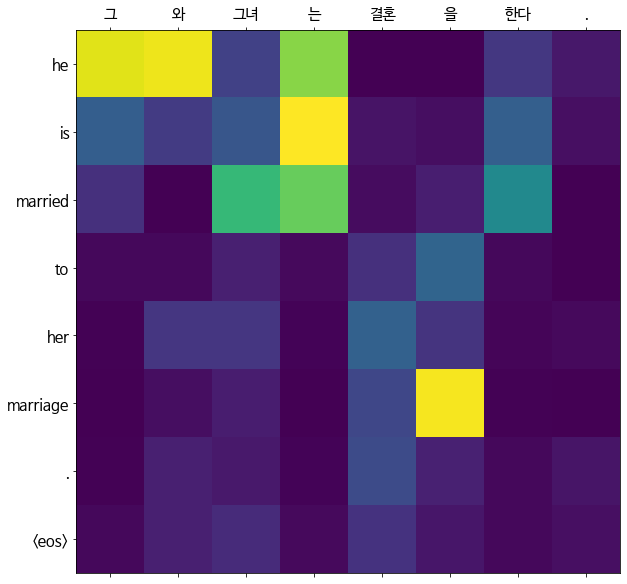

In [ ]:
translate("그와 그녀는 결혼을 한다.", encoder, decoder)

국문: ['영화관', '에서', '영화', '를', '보', '고', '싶', '다', '.']
번역을 수행한 영문: i want to play a movie in the screen . <eos> 


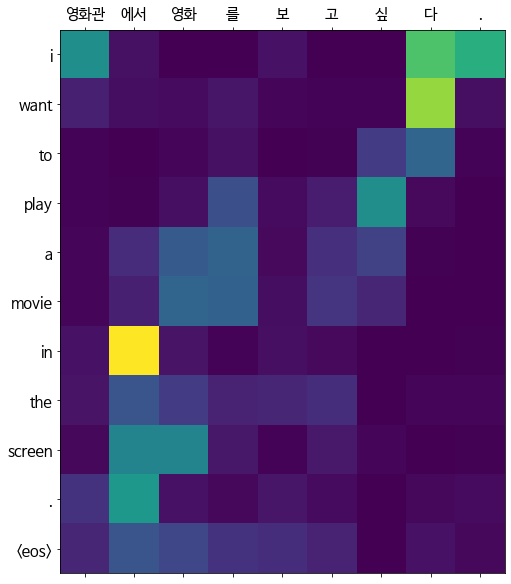

In [ ]:
translate("영화관에서 영화를 보고 싶다.", encoder, decoder)

국문: ['아이', '들', '은', '학교', '에', '간다', '.']
번역을 수행한 영문: they were in the school . <eos> 


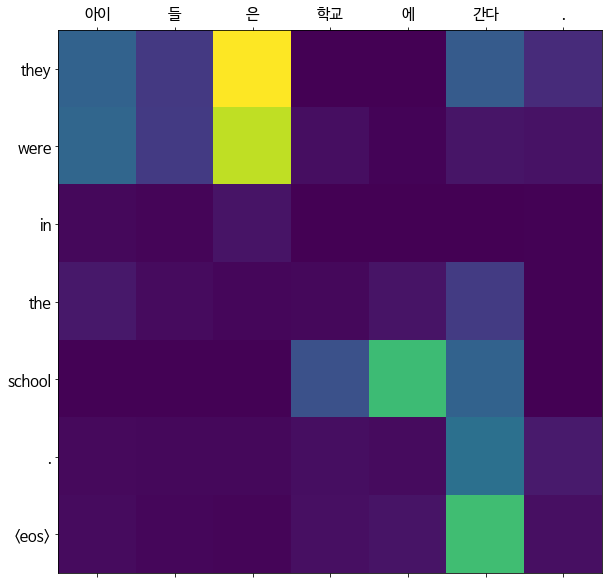

In [ ]:
translate("아이들은 학교에 간다.", encoder, decoder)

국문: ['동물', '은', '동물원', '에', '있', '다', '.']
번역을 수행한 영문: the animals are being found in the zoo s . <eos> 


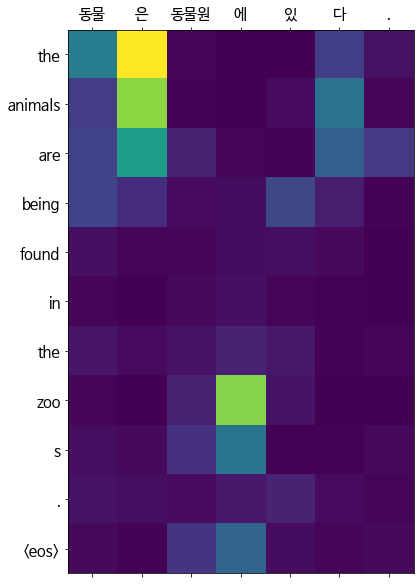

In [ ]:
translate("동물은 동물원에 있다.", encoder, decoder)

국문: ['큰', '문제', '가', '발생', '하', '다', '.']
번역을 수행한 영문: the problem is a major point . <eos> 


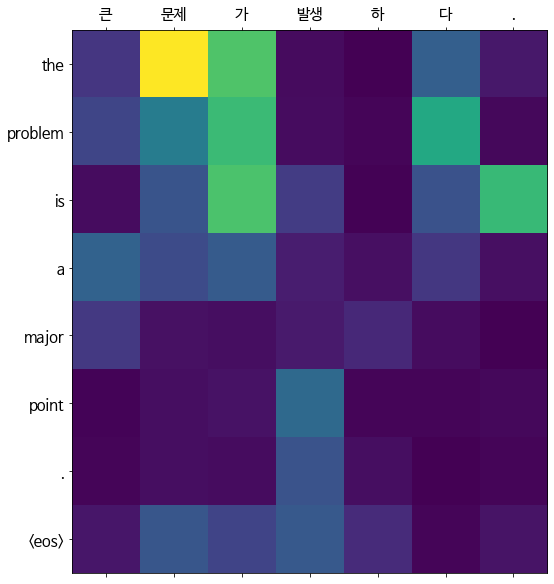

In [ ]:
translate("큰 문제가 발생하다.", encoder, decoder)

### **5-4. 최종 평가**

|**학습 횟수**|**국문**|**번역을 수행한 영문**|**결과**|
|:---:|:---:|:---:|:---:|
|**20**|**오바마는 대통령이다.**|**obama is a** former **president**.|**○**|
|**50**|**오바마는 대통령이다.**|he said he will be a big battle.|**✕**|
|**20**|**시민들은 도시 속에 산다.**|they are also a huge number of the **city**.|**△**|
|**50**|**시민들은 도시 속에 산다.**|they snaked in **cities** , cheers took place across the **city** to enjoy the city sidewalks .|**△**|
|**20**|**커피는 필요 없다.**|he says.|**✕**|
|**50**|**커피는 필요 없다.**|the level of vitamin helps you match much **coffee**.|**△**|
|**20**|**일곱 명의 사망자가 발생했다.**|six **were killed**.|**△**|
|**50**|**일곱 명의 사망자가 발생했다.**|**seven people were killed.**|**○**|
|**20**|**여름은 날씨가 덥다.**|**the summer** morning , the **weather** is the best way to get the new **weather**.|**△**|
|**50**|**여름은 날씨가 덥다.**|**the summer is** expected.|**△**|
|**20**|**그와 그녀는 결혼을 한다.**|**he is married to her** marriage.|**○**|
|**50**|**그와 그녀는 결혼을 한다.**|her marriage **are married** in marriage.|**△**|
|**20**|**영화관에서 영화를 보고 싶다.**|i **want to** play a **movie in the screen**.|**○**|
|**50**|**영화관에서 영화를 보고 싶다.**|you don t.|**✕**|
|**20**|**아이들은 학교에 간다.**|they were in the **school**.|**△**|
|**50**|**아이들은 학교에 간다.**|**children are** all at **school** to **school**.|**○**|
|**20**|**동물은 동물원에 있다.**|**the animals are** being found **in the zoo** s.|**○**|
|**50**|**동물은 동물원에 있다.**|**the animal is** also a popular wild that they were amazed at a **zoo**.|**△**|
|**20**|**큰 문제가 발생하다.**|the **problem** is a major point .|**△**|
|**50**|**큰 문제가 발생하다.**|a key **problem** is a **big problem**.|**△**|

이번 프로젝트에서는 번역 모델을 만들어 보았다. 그 결과 전체적으로 번역이 잘 이루어지지 않았고, 주어나 동사 부분만 한두개 맞추는 모습을 보였다. 데이터를 살펴보았는데, he, she 같은 데이터에서 많이 나온 주어의 경우 부분은 잘 맞추는 편이었다. 하지만 신기하게 동사나 어미를 붙이는 순간 문장이 잘 안나오는 결과가 많았다. 데이터의 내용이 전반적으로 경제나 정치, 사회 등 일반적이지 않은 내용이 많아 일반 문장의 경우 더 번역을 잘 수행하지 못하는 것 같다는 생각이 들었다. 생각보다 하이퍼 파라미터를 조정하여도 잘 맞추는 모습을 보이지 않는 것으로 보아 데이터를 좀 더 보완될 필요성이 느껴진다.

## **6. 회고**


### **6-1. 프로젝트 회고**


이번 프로젝트를 수행하면서 가장 많고 다양한 오류들을 접한 것 같다.  

가장 문제가 되었던 부분은 학습 함수 부분인데, 토큰화를 잘 진행했음에도 불구하고 학습을 진행하면 계속 start를 찾을 수 없다는 오류가 발생했다. 그래서 맨 처음에는 내가 작업한 코드와 다른 분들의 코드를 비교해 보았는데 코드상의 다른 점이 없었고, 그래서 일단 start로 문장의 시작을 구분한 분들의 코드를 그대로 가져와 돌려보았는데 그 조차 똑같은 오류가 발생했다. start가 없다는 의미가 딕셔너리나 리스트 내에 start로 된 부분을 찾을 수 없다는 의미였는데, 데이터 확인을 해보면 멀쩡히 출력 되어서 너무 답답했다. 그래서 또 다른 분의 코드를 봤는데 이 분은 기본적인 전처리 진행 후 데이터프레임으로 형태 변환을 진행해서 작업을 진행하셨고, 시작과 끝을 start-end가 아닌 sos-eos로 구분하셨기에 그 분의 코드를 활용해 작업해보았다. 그랬더니 코드는 잘 돌아갔는데, 정작 내가 작성한 처음의 코드가 하나도 남지 않아서 너무 아쉬웠다.  

두번째로 애를 먹었던 부분은 역시나 저번과 똑같이 한글 폰트 문제였다. 노드에서 제시한대로 작업했으나 제대로 출력이 되지 않았고, 때문에 여러 방법을 시도해서 시각화 하는 것에 성공했다. 그런데 여기서 문제는 한글 폰트 설정이 끝나고 무조건 커널을 재연결 해줘야 했는데, 처음에 학습 에폭을 크게 돌렸으나 다시 커널을 연결해야 했기 때문에 다시 학습을 해야 한다는 점이었다. 보통 시각화를 진행하는 부분이 뒷부분에 많이 나오기 때문에 지금까지 학습 시간이 너무 허무했다. 그래서 로컬을 활용하는 게 좋다는 생각이 들었고, 만약 COLAB을 사용하더라도 먼저 그냥 아무 표라도 시각화해서 한글이 잘 나오는지 확인해봐야겠다는 생각이 들었다.  

그 외에도 과적합을 막기 위해 EARLY STOPPING을 사용하고 싶었으나, 코드가 안돌아갔다. 이유를 확인해보니 MODEL.FIT을 안하면 ES을 사용할 수 없다고 한다. 그런 부분은 처음 알았기에 조금 새로웠다.  

그리고 학습을 진행하면서 다양한 파라미터를 만져봤는데, `run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)` 오류가 자주 떴다. 이유를 찾아보았으나 처음에는 너무 사람들의 다양한 의견 때문에 오류의 정체를 알기 어려웠는데, CPU 보다 작업하려는 내용이 크면 발생하는 오류인 것 같았다. 이런 오류는 처음 봐서 신기하기도 했고, 오류의 내용을 좀 더 구체적으로 CPU가 부족하다고 적었으면 이렇게 오래 고민하지 않아도 될 것 같다는 생각이 들어서 이런 부분을 조금 보완해줬으면 하는 생각이 들었다.  

그리고 다양한 EPOCH,BATCH SIZE를 설정해 보았으나 LOSS 값은 거의 변동이 없었다. 한번 실수로 옵티마이저 설정 부분 코드를 안돌렸는데, 이 경우에는 어쩐지 2.3 이하로 LOSS 값이 안떨어지는 현상이 발생해서 옵티마이저 설정이 중요하구나를 느꼈다. 그리고 EPOCH이나 BATCH SIZE도 중요하지만 결국에 데이터의 사이즈나 상태에 따라 결과가 많이 차이나는 것 같아서 이번에도 데이터의 중요성을 더 크게 느낀 것 같다.

### **6-2. 참고자료**


1. https://github.com/hayaseleu/SSAC_classifications/blob/master/Going_deeper(NLP)/Going%20Deeper(NLP)_SSAC%208.%20Seq2seq%EC%9C%BC%EB%A1%9C%20%EB%B2%88%EC%97%AD%EA%B8%B0%20%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb  
2. https://github.com/miinkang/AI_Project_AIFFEL/blob/main/%5BGD-08%5Dattention_based_seq2seq_translation.ipynb  
3. https://github.com/eunji1/Aiffel/blob/main/NLP/NLP%5B08%5Dtranslation.ipynb
4. https://github.com/YAGI0423/aiffel_going_deeper_nlp/blob/main/going_deeper_08/GD08_v3_1.ipynb  
5. https://github.com/keras-team/keras/issues/12806  
6. https://stackoverflow.com/questions/49665757/how-to-add-report-tensor-allocations-upon-oom-to-runoptions-in-keras   
7. https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/api_docs/python/client.html  
8. https://colab.research.google.com/github/nicewook/datascience_exercise/blob/master/korean_font_on_matplotlib.ipynb#scrollTo=O_cpXzdg0cjb